In [1]:
import torch
from fastai.text.all import *

%matplotlib inline

In [2]:
dataset_path = untar_data(URLs.IMDB)
dataset_files = get_text_files(dataset_path, folders=['train', 'test'])

tok_rules = [
    lowercase,
    fix_html,
    spec_add_spaces,
    rm_useless_spaces,
]
x_tfms = [
    Tokenizer.from_folder(dataset_path, tok=TokenizeWithRules(WordTokenizer(), tok_rules), rules=[]),
    Numericalize(max_vocab=16_000)
]
y_tfms = [
    parent_label, 
    Categorize()
]

splitter = GrandparentSplitter(train_name='train', valid_name='test')(dataset_files)
dsets = Datasets(dataset_files, [x_tfms, y_tfms], splits = splitter)
dloaders = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

2023-11-28 23:55:00.474542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 23:55:01.100832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-28 23:55:01.591607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 23:55:01.595355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 23:55:01.595391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [3]:
vocab_len = len(x_tfms[1].vocab)
vocab_len

16008

In [4]:
dloaders = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input, bs=16)
dloaders.one_batch()

(TensorText([[12628,   506,   103,  ...,    30,   158,   699],
             [  153,   153,   153,  ...,     1,     1,     1],
             [  722,   731,     9,  ...,     1,     1,     1],
             ...,
             [    0,    88,    13,  ...,     1,     1,     1],
             [   23,    78,    40,  ...,     1,     1,     1],
             [    0,     0,    10,  ...,     1,     1,     1]], device='cuda:0'),
 TensorCategory([1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1],
                device='cuda:0'))

## LSTM model
LSTM attempts to mitigate problems with vanishing and exploding gradients by using 2 hidden states:
* cell state - retains memory of what happened much earlier in the sentence (long short-term memory)
* hidden state - focuses on the next token to predict

In [13]:
class LstmModelCallback(Callback):
    def after_batch(self): 
        self.model.reset()
    def before_batch(self):
        batch_shape = self.x.shape
        self.model.setup(batch_shape[0])

class LstmCell(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        concat_size = hidden_size + input_size # the input is concatinated with hidden state in forward pass
        
        self.hidden_state = None
        self.cell_state = None
        
        # gates
        self.forget_gate = nn.Linear(in_features = concat_size, out_features = hidden_size)
        self.input_gate = nn.Linear(concat_size, hidden_size)
        self.cell_gate = nn.Linear(concat_size, hidden_size)
        self.output_gate = nn.Linear(concat_size, hidden_size)
    
    def forward(self, x):
        h = torch.cat((x, self.hidden_state), dim=1)
        c = self.cell_state
        
        f = torch.sigmoid(self.forget_gate(h))
        c = c * f
        
        i = torch.sigmoid(self.input_gate(h))
        cl = torch.tanh(self.cell_gate(h))
        c = c + (i * cl)
        
        o = torch.sigmoid(self.input_gate(h))
        o = o * torch.tanh(c)
        
        self.hidden_state = o
        self.cell_state = c
        
        return o
    
    def reset(self):
        self.hidden_state = None
        self.cell_state = None

    def setup(self, batch_size):
        self.hidden_state = torch.zeros((batch_size, self.hidden_size)).normal_(0, 0.01).to(device='cuda')
        self.cell_state = torch.zeros((batch_size, self.hidden_size)).normal_(0, 0.01).to(device='cuda')
    
        

class Lstm(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm_cell = LstmCell(embedding_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # recurrence
        h = None
        for i in range(x.shape[1]):
            h = self.embedding(x[:,i])
            h = self.lstm_cell(h)
        return self.output(h)
        
        
    def reset(self):
        # called by LstmModelCallback
        self.lstm_cell.reset()
        
    def setup(self, batch_size):
        self.lstm_cell.setup(batch_size)
        
        
lstm = Lstm(vocab_len, 16, 32, 2)
lstm.cuda()

learner = Learner(dloaders, 
                  lstm, 
                  loss_func=F.cross_entropy, 
                  metrics=accuracy, 
                  cbs=LstmModelCallback)

b = dloaders.one_batch()
print(b[0].shape)
print(b[1].shape)
lstm.setup(b[0].shape[0])
learner.forward(b[0]).shape


torch.Size([16, 2789])
torch.Size([16])


torch.Size([16, 2])

SuggestedLRs(valley=4.365158383734524e-05)

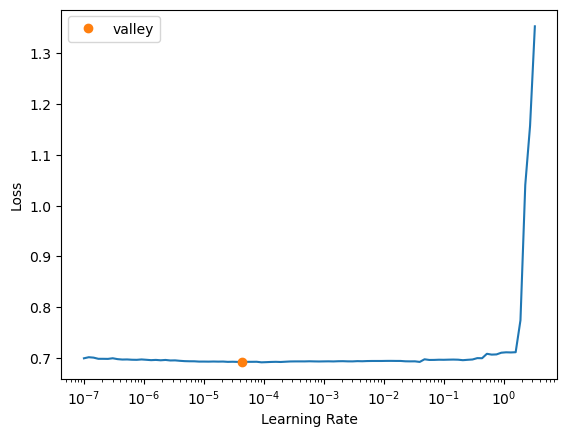

In [12]:
learner.lr_find()

In [7]:
learner.fit_one_cycle(4, 9.12e-05)

In [18]:
# clean gpu memory
import gc

learner = None
lstm = None
gc.collect()
torch.cuda.empty_cache()